# `mltsp` Tutorial: Epilepsy Detection Using EEG Data

In this example we'll use the [`mltsp`](http://github.com/mltsp/mltsp/) library to compare various techniques for epilepsy detection using a classic EEG time series dataset from [Andrzejak et al.](http://www.meb.uni-bonn.de/epileptologie/science/physik/eegdata.html). The raw data are separated into five classes: Z, O, N, F, and S; we will consider a three-class classification problem of distinguishing normal (Z, O), interictal (N, F), and ictal (S) signals.

First, we'll load the data and inspect a representative time series from each class:

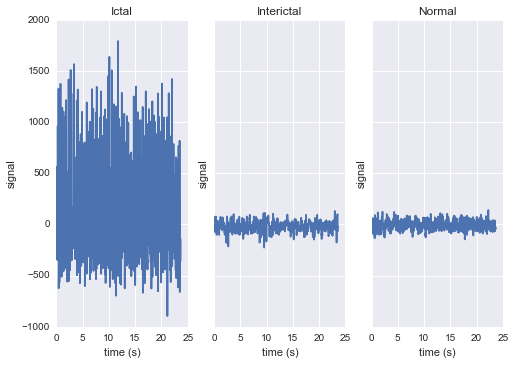

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

from mltsp import datasets

eeg = datasets.fetch_andrzejak()
eeg.classes = eeg.classes.astype('U16') #  allocate memory for longer class names
eeg.classes[np.logical_or(eeg.classes=='Z', eeg.classes=='O')] = 'Normal'
eeg.classes[np.logical_or(eeg.classes=='N', eeg.classes=='F')] = 'Interictal'
eeg.classes[eeg.classes=='S'] = 'Ictal'
fig, ax = plt.subplots(1, len(np.unique(eeg.classes)), sharey=True)
for label, subplot in zip(np.unique(eeg.classes), ax):
    i = np.where(eeg.classes == label)[0][0]
    subplot.plot(eeg.times[i], eeg.measurements[i])
    subplot.set(xlabel='time (s)', ylabel='signal', title=label)

## Featurization
Once the data is loaded, we can generate features for each time series using the [`mltsp.featurize`](https://mltsp.readthedocs.org/en/latest/api/mltsp.featurize.html) module, which will then be used to train machine learning models. Here we've chosen a few generic features that do not have any special biological significance.

In [2]:
from mltsp import featurize

features_to_use = ['amplitude',
                   'percent_beyond_1_std',
                   'maximum',
                   'max_slope',
                   'median',
                   'median_absolute_deviation',
                   'percent_close_to_median',
                   'minimum',
                   'skew',
                   'std',
                   'weighted_average']
fset_mltsp = featurize.featurize_time_series(eeg.times, eeg.measurements,
                                             None, features_to_use,
                                             eeg.classes)
print(fset_mltsp)

<xray.Dataset>
Dimensions:                    (channel: 1, name: 500)
Coordinates:
  * channel                    (channel) int64 0
  * name                       (name) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
    target                     (name) <U16 'Normal' 'Normal' 'Normal' ...
Data variables:
    amplitude                  (name, channel) float64 143.5 211.5 165.0 ...
    maximum                    (name, channel) float64 141.0 169.0 184.0 ...
    std                        (name, channel) float64 40.41 48.81 47.14 ...
    percent_close_to_median    (name, channel) float64 0.505 0.6405 0.516 ...
    minimum                    (name, channel) float64 -146.0 -254.0 -146.0 ...
    median_absolute_deviation  (name, channel) float64 28.0 32.0 31.0 31.0 ...
    median                     (name, channel) float64 -4.0 -51.0 13.0 -4.0 ...
    percent_beyond_1_std       (name, channel) float64 0.1626 0.1455 0.1523 ...
    weighted_average           (name, channel) float64 -4.132 -52.44 1

The output of `featurize_time_series` is an `xray.Dataset` which contains all the feature information needed to train a machine learning model: feature values are stored as data variables, and the time series index/class label are stored as coordinates (the `channel` coordinate will be used later for multi-channel data).

Custom feature functions not built into `mltsp` may be passed in using the `custom_functions` keyword, either as a dictionary `{feature_name: function}`, or as a [dask graph](http://dask.pydata.org/en/latest/custom-graphs.html). Functions should take three arrays `times, measurements, errors` as inputs; details can be found in the `mltsp.featurize` [documentation](https://mltsp.readthedocs.org/en/latest/api/mltsp.featurize.html#mltsp.featurize.featurize_time_series). Here we'll compute five standard features for EEG analysis provided by [Guo et al. (2012)](http://linkinghub.elsevier.com/retrieve/pii/S0957417411003253).

In [3]:
import scipy.stats

guo_features = {
    'mean': lambda t, m, e: np.mean(m),
    'std': lambda t, m, e: np.std(m),
    'mean2': lambda t, m, e: np.mean(m ** 2),
    'abs_diffs': lambda t, m, e: np.sum(np.abs(np.diff(m))),
    'skew': lambda t, m, e: scipy.stats.skew(m)
}
fset_guo = featurize.featurize_time_series(eeg.times, eeg.measurements, None, 
                                           guo_features.keys(), eeg.classes, 
                                           custom_functions=guo_features)
print(fset_guo)

<xray.Dataset>
Dimensions:    (channel: 1, name: 500)
Coordinates:
  * channel    (channel) int64 0
  * name       (name) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    target     (name) <U16 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' ...
Data variables:
    std        (name, channel) float64 40.41 48.81 47.14 47.07 44.91 45.02 ...
    mean2      (name, channel) float64 1.65e+03 5.133e+03 2.384e+03 ...
    abs_diffs  (name, channel) float64 4.695e+04 6.112e+04 5.127e+04 ...
    skew       (name, channel) float64 0.0328 -0.09271 -0.0041 0.06368 ...
    mean       (name, channel) float64 -4.132 -52.44 12.71 -3.992 -18.0 ...


The EEG time series considered here consist of univariate signal measurements along a uniform time grid. But `featurize_time_series` also accepts multi-channel data; to demonstrate this, we will decompose each signal into five frequency bands using a discrete wavelet transform as suggested by [Subasi (2005)](http://www.sciencedirect.com/science/article/pii/S0957417404001745), and then featurize each band separately using the five functions from above.

In [4]:
import pywt

n_channels = 5
eeg.dwts = [pywt.wavedec(m, pywt.Wavelet('db1'), level=n_channels-1) for m in eeg.measurements]
fset_dwt = featurize.featurize_time_series(None, eeg.dwts, None, 
                                           guo_features.keys(), eeg.classes, 
                                           custom_functions=guo_features)
print(fset_dwt)

<xray.Dataset>
Dimensions:    (channel: 5, name: 500)
Coordinates:
  * channel    (channel) int64 0 1 2 3 4
  * name       (name) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    target     (name) <U16 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' ...
Data variables:
    std        (name, channel) float64 112.5 72.97 48.17 25.77 10.15 119.8 ...
    mean2      (name, channel) float64 1.294e+04 5.362e+03 2.321e+03 664.4 ...
    abs_diffs  (name, channel) float64 2.513e+04 1.806e+04 3.241e+04 ...
    skew       (name, channel) float64 -0.0433 0.06578 0.2999 0.1239 0.1179 ...
    mean       (name, channel) float64 -17.08 -6.067 -0.9793 0.1546 0.03555 ...


The output featureset has the same form as before, except now the `channel` coordinate is used to index the features by the corresponding frequency band. The functions in `mltsp.build_model` and `mltsp.predict` all accept featuresets from single- or multi-channel data, so no additional steps are required to train models or make predictions for multichannel featuresets using the `mltsp` library.

## Model Building
Model building in `mltsp` is handled by the `build_model_from_featureset` function in the `mltsp.build_model` submodule. The featureset output by `featurize_time_series` contains both the feature and target information needed to train a model; `build_model_from_featureset` is simply a wrapper that calls the `fit` method of a given `scikit-learn` model with the appropriate inputs. In the case of multichannel features, it also handles reshaping the featureset into a (rectangular) form that is compatible with `scikit-learn`.

For this example, we'll test a random forest classifier for the built-in `mltsp` features, and a 3-nearest neighbors classifier for the others, as suggested by [Guo et al. (2012)](http://linkinghub.elsevier.com/retrieve/pii/S0957417411003253).

In [5]:
from mltsp.build_model import build_model_from_featureset
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

train, test = train_test_split(np.arange(len(eeg.classes)))

model_mltsp = build_model_from_featureset(fset_mltsp.isel(name=train), 
                                          RandomForestClassifier(n_estimators=1000,
                                                                 max_features='auto',
                                                                 random_state=0))
model_guo = build_model_from_featureset(fset_guo.isel(name=train), 
                                        KNeighborsClassifier(n_neighbors=3))
model_dwt = build_model_from_featureset(fset_dwt.isel(name=train), 
                                        KNeighborsClassifier(n_neighbors=3))

## Prediction
Making predictions for new time series based on these models follows the same pattern: first the time series are featurized using `featurize_time_series`, and then predictions are made based on these features using `mltsp.predict.model_predictions`.

In [6]:
from mltsp.predict import model_predictions

preds_mltsp = model_predictions(fset_mltsp, model_mltsp, return_probs=False)
preds_guo = model_predictions(fset_guo, model_guo, return_probs=False)
preds_dwt = model_predictions(fset_dwt, model_dwt, return_probs=False)

print("Built-in MLTSP features: training accuracy={:.2%}, test accuracy={:.2%}".format(
        np.mean(preds_mltsp[train] == eeg.classes[train]), 
        np.mean(preds_mltsp[test] == eeg.classes[test])))
print("Guo et al. features: training accuracy={:.2%}, test accuracy={:.2%}".format(
        np.mean(preds_guo[train] == eeg.classes[train]), 
        np.mean(preds_guo[test] == eeg.classes[test])))
print("Wavelet transform features: training accuracy={:.2%}, test accuracy={:.2%}".format(
        np.mean(preds_dwt[train] == eeg.classes[train]), 
        np.mean(preds_dwt[test] == eeg.classes[test])))

Built-in MLTSP features: training accuracy=100.00%, test accuracy=90.40%
Guo et al. features: training accuracy=92.27%, test accuracy=85.60%
Wavelet transform features: training accuracy=97.60%, test accuracy=98.40%


The workflow presented here is intentionally simplistic and omits many important steps such as feature selection, model parameter selection, etc. Since we make use of standard `scikit-learn` models, additional steps can be incorporated in exactly the way as for any other (non-time domain) machine learning problem.